In [2]:
import networkx as nx
import pandas as pd
import csv        
import numpy as np
import matplotlib.pyplot as plt

In [3]:
MULTI_GRAPH_UNI = "../PoolsLiquidities/LiquidityPoolsWithinTime/UniSwapV2.csv"
MULTI_GRAPH_SUSHI = "../PoolsLiquidities/LiquidityPoolsWithinTime/SushiSwap.csv"
NUM_BLOCKS = 100
FIRST_BLOCK = 10060850
LAST_BLOCK = 15076596

In [4]:
class MultiGraphs:
    
    def __init__(self, file_path, dex_name, num_blocks):
        self.df_pools = pd.read_csv(file_path)
        self.dex_name = dex_name
        self.graphs = []
        for i in range(0, num_blocks):
            str_now = "count" + str(i)
            graph_new = WeightedDexGraph(self.df_pools, dex_name, str_now)
            self.graphs.append(graph_new)
    
    def get_centralities(self, node_address):
        cnt = 0
        ans = []
        cnt = 0
        for graph in self.graphs:
            cnt = cnt + 1
            vec_ans = graph.get_eigen_centrality()
            ans.append(vec_ans[node_address])
            print(cnt, vec_ans[node_address])
        return ans
    
    def draw_centralities(self, node_address):
        
        y = self.get_centralities(node_address)
        
        dis = (LAST_BLOCK - FIRST_BLOCK) / 100
        
        x = []
        now = FIRST_BLOCK
        for i in range(0,NUM_BLOCKS):
            x.append(now)
            now += dis
            
        node_name = self.graphs[0].get_node_name(node_address)
        
        plt.plot(x, y)
        plt.ylabel(f"{node_name} centralities during time")
        plt.xlabel("block number")
        plt.title(f"Centrality {node_name} in {self.dex_name}")
    
    def get_node_address(token_name):
        
        y = self.get_centralities(node_address)
        
 
        

In [5]:
class DexPools:
    
    def __init__(self, file_path, dex_name):
        
        self.df_pools = pd.read_csv(file_path)
        self.name = dex_name
    
    def filter_first_blocks(self, pools_inp, block_first, block_last):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"FirstBlock":"int","LastBlock":"int"})
        df_pools_out = df_pools_out[df_pools_out.FirstBlock >= block_first]
        df_pools_out = df_pools_out[df_pools_out.FirstBlock <= block_last]
        return df_pools_out
    
    def filter_last_blocks(self, pools_inp, block_first, block_last):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"FirstBlock":"int","LastBlock":"int"})
        df_pools_out = df_pools_out[df_pools_out.LastBlock >= block_first]
        df_pools_out = df_pools_out[df_pools_out.LastBlock <= block_last]
        return df_pools_out
    
    def filter_count(self, pools_inp, cnt_min, cnt_max):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"CntTransfer":"int"})
        df_pools_out = df_pools_out[df_pools_out.CntTransfer >= cnt_min]
        df_pools_out = df_pools_out[df_pools_out.CntTransfer <= cnt_max]
        return df_pools_out
    
    def find_lost_pools(self):
        df_pools_out = self.filter_count(self.df_pools, 100000, 10000000000)
        df_pools_out = self.filter_last_blocks(df_pools_out, 0, 14500000)
        return df_pools_out
    
    def get_edge_cnt(self, token1, token2):
        df_pools = self.df_pools[self.df_pools.AddressToken0 == token1]
        df_pools = df_pools[df_pools.AddressToken1 == token2]
        if(len(df_pools) == 0):
            return None
        else:
            return df_pools.iloc[0]['CntTransfer']

In [6]:
COLUMN_NAME = ["AddressToken0","AddressToken1"]

class WeightedDexGraph:

    def __init__(self, df_pools, name, cnt_transfer = "CntTransfer"):
        
        self.crypto_graph = nx.Graph()
        self.name = name
        
        symbol = []
        
        nx.set_node_attributes(self.crypto_graph, symbol, "symbol")

        for row in df_pools.index:
                
            sell_token = df_pools['AddressToken0'][row]
            buy_token = df_pools['AddressToken1'][row]
            
            count_transfer = df_pools[cnt_transfer][row]
            
            self.add_node(self.crypto_graph, buy_token)
            self.add_node(self.crypto_graph, sell_token)
            
            sell_symbol = df_pools['SymbolToken0'][row]
            buy_symbol = df_pools['SymbolToken1'][row]
                        
            self.crypto_graph.nodes[sell_token]["symbol"] = sell_symbol
            self.crypto_graph.nodes[buy_token]["symbol"] = buy_symbol
            
            if(not(self.crypto_graph.has_edge(buy_token, sell_token)) and count_transfer != 0):
                self.crypto_graph.add_edge(buy_token, sell_token, weight = count_transfer)
                
    def get_node_name(self, node_address):
         return self.crypto_graph.nodes[node_address]["symbol"]
                
    def get_eigen_centrality(self):
        
        eigen_centrality = nx.eigenvector_centrality(self.crypto_graph,weight = 'weight', max_iter = 100000, 
                                                     tol = 1e-4) 
        return eigen_centrality
    
    def get_reversed_sorted_ranks(self, dict_ranks):
        
        dict_ans = dict(sorted(dict_ranks.items(), key = lambda x:-1 * x[1]))
        return dict_ans
    
    def change_ranks_with_symbol(self, dict_ranks):
        
        dict_ans = [(self.crypto_graph.nodes[key]["symbol"], value) 
                        for (key, value) in dict_ranks.items()]
        return dict_ans
    
    def get_top_ranks(self, rank_inp, number_of_tokens):
        return rank_inp[0:number_of_tokens - 1]
        
    def get_page_rank(self):
        
        page_rank = nx.pagerank(self.crypto_graph,weight = 'weight', max_iter = 1000, alpha=0.9, 
                               tol = 1e-4)
        return page_rank
    
    
    
    def get_degree(self, node_name):
        if(not self.crypto_graph.has_node(node_name)):
            return 0
        return self.crypto_graph.degree[node_name]

    def add_node(self, graph_input, token_input):
        if(not graph_input.has_node(token_input)):
            graph_input.add_node(token_input)
    
    def get_list_degree(self):
        degree_node_list = self.crypto_graph.degree()
        degree_list = [deg[1] for deg in degree_node_list]
        degree_list.sort()
        return degree_list

    def print(self, file_path_output):
        graph_file = open(file_path_output, 'w')
        graph_writer = csv.writer(graph_file)
        graph_writer.writerow(COLUMN_NAME)
        for edge in self.crypto_graph.edges:
             graph_writer.writerow(edge)

    def get_best_vertices(self, num):
        degree_node_list = self.crypto_graph.degree()
        degree_node = sorted(degree_node_list, key = lambda vertex: vertex[1])    
        return degree_node
    
    def get_count_deg(self, degree_list):
        count_deg = [(num, degree_list.count(num)) for num in degree_list]
        count_deg = [*set(count_deg)]
        count_deg = sorted(count_deg, key = lambda x: x[0])
        return count_deg
    
    def draw_plot_degree(self, degree_list, flag = False):
        
        count_deg = self.get_count_deg(degree_list)
        
        x = np.array([tmp[1] for tmp in count_deg])
        y = -0.8435 * x + 4.6
        print(x, y)

        plt.xscale('log')
        plt.yscale('log')
        plt.plot([tmp[1] for tmp in count_deg], [tmp[0] for tmp in count_deg])
        if(flag):
            plt.xlabel("Log Count Nodes")
            plt.ylabel("Log Degree")
            plt.show()
 
        plt.plot(x, y)
        plt.ylabel("Log Count Nodes")
        plt.xlabel("Log Degree")
        plt.title(f"{self.name} Log Log plot")
        
        plt.show()
    
    def print_info(self, is_avg_clustering = True, is_plot = True, is_page_rank = True,
            is_betweeness = False, is_eigen = False, is_closeness = False):
        
        print(f"Number of Nodes {self.name} is: ", self.crypto_graph.number_of_nodes())
        print(f"Number of Edges {self.name} is: ", self.crypto_graph.number_of_edges())
        print(f"Average Degree {self.name} is: ", (self.crypto_graph.number_of_edges() * 2) 
      / self.crypto_graph.number_of_nodes())
        if(is_avg_clustering):
            print(f"Average Clustering {self.name} is: ", nx.average_clustering(uni_graph.crypto_swaps_graph))
        if(is_plot):
            degree_list_graph = self.get_list_degree()
            self.draw_plot_degree(degree_list_graph)
            
        if(is_page_rank):    
            page_rank = self.get_sorted_page_rank_nodes()
            print(f"{self.name} Top 100 Tokens: ", page_rank[-1:-100:-1])
        
        if(is_betweeness):
            betweenness_centrality = nx.betweenness_centrality(dex_graph.crypto_swaps_graph)
            betweenness_centrality = sorted(betweenness_centrality.items(), key = operator.itemgetter(1))    
            print("Betweenness", betweenness_centrality)
            
        if(is_eigen):
            eigen_vector_centrality = nx.eigenvector_centrality(dex_graph.crypto_swaps_graph)
            print("EigenVector", eigen_vector_centrality)
        
        if(is_closeness):
            closeness_centrality = nx.closeness_centrality(dex_graph.crypto_swaps_graph)
            closeness_centrality = sorted(closeness_centrality.items(), key = operator.itemgetter(1))    
            print("Closeness", closeness_centrality)
            
        print("Components:")
        num_componenent = [x for x in nx.connected_components(self.crypto_graph)]
        print([len(component) for component in num_componenent])
        
        
        num_nodes = self.crypto_graph.number_of_nodes()
        max_edges = (num_nodes * (num_nodes - 1)) / 2
        print("Density of the graph is: ", (self.crypto_graph.number_of_edges() * 2) / (max_edges))
        
    def check_power_law(self):
            
        count_deg = self.get_count_deg(self.get_list_degree())

        x = [np.log(sample[0]) for sample in count_deg]
        y = [np.log(sample[1]) for sample in count_deg]
        x2 = sm.add_constant(x)
        est = sm.OLS(y, x2)
        print(est.fit().summary())
        print(est.fit().f_pvalue)
    
    def plot_degree(self, degree_list):
        
        x_axis = [a[0] for a in degree_list]
        y_axis = [a[1] for a in degree_list]
        plt.plot(x_axis, y_axis)
        plt.ylabel("Count Nodes")
        plt.xlabel("Degree")
        plt.title(f"{self.name} Degree Distribution Plot")
        
        plt.show()
    
    def plot_log_degree(self, degree_list):
        eps = 1e-7
        x_axis = [np.log(a[0] + eps) for a in degree_list]
        y_axis = [np.log(a[1] + eps) for a in degree_list]
        plt.plot(x_axis, y_axis)
        plt.ylabel("Log Count Nodes")
        plt.xlabel("Log Degree")
        plt.title(f"{self.name} Log Degree Distribution Plot")
        
        plt.show()
    
        

In [7]:
   def get_block_range(index):
        dis = (LAST_BLOCK - FIRST_BLOCK) / 100
        ans = [dis * index + FIRST_BLOCK, dis * (index + 1) + FIRST_BLOCK]
        return ans

<h2><span style="color:orange">Making Without Filter Dex Pools</span></h2>

In [8]:
uni_dex = DexPools("../PoolsLiquidities/LiquidityPools/UniSwapV2.csv", "UniSwapV2")
sushi_dex = DexPools("../PoolsLiquidities/LiquidityPools/SushiSwap.csv", "SushiSwap")

<h2><span style="color:orange">Making Without Filter Dex Graphs</span></h2>

In [9]:
uni_graph = WeightedDexGraph(uni_dex.df_pools, "UniSwapV2")
sushi_graph = WeightedDexGraph(sushi_dex.df_pools, "SushiSwap")

<h2><span style="color:orange">Make uniswap and sushiswap graph files</span></h2>

In [10]:
nx.write_weighted_edgelist(uni_graph.crypto_graph, "UniswapWeighted.gz")

In [11]:
nx.write_weighted_edgelist(sushi_graph.crypto_graph, "SushiWeighted.csv")

<h2><span style="color:orange">Eigen Centrality for Graphs</span></h2>

In [12]:
eigen_vec = uni_graph.get_eigen_centrality()
eigen_vec = uni_graph.get_reversed_sorted_ranks(eigen_vec)
eigen_vec = uni_graph.change_ranks_with_symbol(eigen_vec)
sushi_graph.get_top_ranks(eigen_vec, 20)

[('WETH', 0.9912290462290068),
 ('USDT', 0.08766130080471124),
 ('USDC', 0.08478963367173886),
 ('DAI', 0.0315343650704104),
 ('SHIB', 0.01725126620079008),
 ('SAITAMA', 0.012961603841174644),
 ('UNI', 0.01082449178594235),
 ('WBTC', 0.009867950601133909),
 ('HEX', 0.00899044688568939),
 ('KISHU', 0.006888508573367725),
 ('LINK', 0.005687801133020519),
 ('AMPL', 0.005673107739601921),
 ('ELON', 0.004966150521683766),
 ('eMax', 0.004517989289839892),
 ('STRONG', 0.004321557464046626),
 ('SUSHI', 0.003938911705197033),
 ('YFI', 0.0038390182753308137),
 ('POLS', 0.0035788471709816538),
 ('SAND', 0.003491794544635936)]

In [19]:
eigen_vec = sushi_graph.get_eigen_centrality()
eigen_vec = sushi_graph.get_reversed_sorted_ranks(eigen_vec)
# print(eigen_vec)
eigen_vec = sushi_graph.change_ranks_with_symbol(eigen_vec)
sushi_graph.get_top_ranks(eigen_vec, 20)

[('WETH', 0.7210405057090393),
 ('USDC', 0.4148125605644069),
 ('USDT', 0.31743442143429745),
 ('SUSHI', 0.23216382577648456),
 ('DAI', 0.23200965897490583),
 ('YFI', 0.09122342176106728),
 ('WBTC', 0.08898564407404234),
 ('CRV', 0.0863893492462936),
 ('SPELL', 0.08605555774870191),
 ('OHM', 0.08562325077670274),
 ('ALCX', 0.0813562565451067),
 ('CVX', 0.07278295594472471),
 ('LINK', 0.06174351500479668),
 ('ILV', 0.05695206449253089),
 ('SNX', 0.050430518776326747),
 ('FTM', 0.048217673810013295),
 ('OHM', 0.047003009569390915),
 ('AAVE', 0.04453116917098987),
 ('COMP', 0.04283099031069086)]

<h2><span style="color:orange">Page Rank Centrality for Graphs</span></h2>

In [13]:
rank_vec = uni_graph.get_page_rank()
rank_vec = uni_graph.get_reversed_sorted_ranks(rank_vec)
rank_vec = uni_graph.change_ranks_with_symbol(rank_vec)
uni_graph.get_top_ranks(rank_vec, 20)

[('WETH', 0.6750021094213728),
 ('USDT', 0.011101512886777114),
 ('USDC', 0.005659313258141766),
 ('DAI', 0.0027044601723589367),
 ('WBTC', 0.000410946149598066),
 ('UNI', 0.00034238821637192786),
 ('DEXTF', 0.00033818870089861666),
 ('UST', 0.0001588272552079643),
 ('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2', 0.00010181443923473564),
 ('zUSD', 9.197419802661877e-05),
 ('PAXG', 8.881614470457878e-05),
 ('🐟', 8.133740957344554e-05),
 ('SHIB', 7.977035896230385e-05),
 ('DOG', 7.223836299418355e-05),
 ('SUSHI', 7.056799787408756e-05),
 ('yDAI+yUSDC+yUSDT+yTUSD', 7.04456957292711e-05),
 ('AVA', 6.914959905938077e-05),
 ('eCell', 6.854140525876321e-05),
 ('HEX', 6.679461128438322e-05)]

In [12]:
rank_vec = sushi_graph.get_page_rank()
rank_vec = sushi_graph.get_reversed_sorted_ranks(rank_vec)
rank_vec = sushi_graph.change_ranks_with_symbol(rank_vec)
sushi_graph.get_top_ranks(rank_vec, 20)

[('WETH', 0.35397750696443103),
 ('USDC', 0.05587655078537564),
 ('USDT', 0.04748929328939108),
 ('DAI', 0.03362380941426781),
 ('SUSHI', 0.025057445569626222),
 ('WBTC', 0.013657237010712342),
 ('OHM', 0.012657063361295861),
 ('CRV', 0.010106590568482125),
 ('YFI', 0.009450324557362125),
 ('SPELL', 0.008710029403860122),
 ('ALCX', 0.008237437865500656),
 ('CVX', 0.00734787995512746),
 ('OHM', 0.006831603694601422),
 ('LINK', 0.006531930879341642),
 ('ILV', 0.005775593482362321),
 ('SNX', 0.005204140133439794),
 ('FTM', 0.004881854387567274),
 ('AAVE', 0.004568060483510861),
 ('COMP', 0.004354451018855253)]

<h2><span style="color:orange">Degree With Weights Graphs</span></h2>

In [14]:
degree_list = dict(uni_graph.crypto_graph.degree(weight = 'weight'))
degree_list = uni_graph.get_reversed_sorted_ranks(degree_list)
degree_list = uni_graph.change_ranks_with_symbol(degree_list)
uni_graph.get_top_ranks(degree_list, 20)

[('WETH', 155699678),
 ('USDT', 13769608),
 ('USDC', 13318534),
 ('DAI', 4953335),
 ('SHIB', 2709783),
 ('SAITAMA', 2035974),
 ('UNI', 1700282),
 ('WBTC', 1550031),
 ('HEX', 1412195),
 ('KISHU', 1082028),
 ('LINK', 893424),
 ('AMPL', 891116),
 ('ELON', 780069),
 ('eMax', 709673),
 ('STRONG', 678818),
 ('SUSHI', 618713),
 ('YFI', 603022),
 ('POLS', 562155),
 ('SAND', 548481)]

In [15]:
degree_list = dict(sushi_graph.crypto_graph.degree(weight = 'weight'))
degree_list = sushi_graph.get_reversed_sorted_ranks(degree_list)
degree_list = sushi_graph.change_ranks_with_symbol(degree_list)
sushi_graph.get_top_ranks(degree_list, 20)

[('WETH', 17714282),
 ('USDC', 2256646),
 ('USDT', 1847276),
 ('DAI', 1500893),
 ('SUSHI', 1050087),
 ('OHM', 648386),
 ('WBTC', 589119),
 ('CRV', 436214),
 ('YFI', 398559),
 ('SPELL', 366502),
 ('ALCX', 344734),
 ('OHM', 326262),
 ('CVX', 308400),
 ('LINK', 264800),
 ('ILV', 241954),
 ('SNX', 219506),
 ('FTM', 204329),
 ('AAVE', 191576),
 ('RUNE', 184941)]

<h2><span style="color:orange">Graphs With Time Limit</span></h2>

In [16]:
uni_multi_graph = MultiGraphs(MULTI_GRAPH_UNI, "UniSwapV2", NUM_BLOCKS)

In [8]:
sushi_multi_graph = MultiGraphs(MULTI_GRAPH_SUSHI, "SushiSwap", NUM_BLOCKS)

1 0.961661140185477
2 0.9710482118789472
3 0.9826264945865324
4 0.985344300245639
5 0.9805299557736972
6 0.9771066652659612
7 0.9869703098068872
8 0.9867913681072997
9 0.9825147687653779
10 0.9795281939910863
11 0.9877185147498059
12 0.98772803146439
13 0.9903758410399662
14 0.9878903851655512
15 0.9817256822178319
16 0.9840393662009171
17 0.9738174856286727
18 0.9838755146865796
19 0.9832270522754082
20 0.9869873991101501
21 0.9886305744674313
22 0.9858786006542487
23 0.9880843821899222
24 0.9879237706011047
25 0.9857866104297629
26 0.9857747630017828
27 0.9811036791278368
28 0.9789842505397048
29 0.9743929993909174
30 0.9627486900115653
31 0.9500001023107925
32 0.9653901032513218
33 0.9770871115872501
34 0.9807606133641068
35 0.9888844058656872
36 0.9896778005012014
37 0.9897013521218138
38 0.9853824524055093
39 0.9890416407258336
40 0.9898747060203732
41 0.9909115643384002
42 0.9910516752156513
43 0.9919933663198517
44 0.9881364351605055
45 0.9836279786167318
46 0.9896636660241153
4

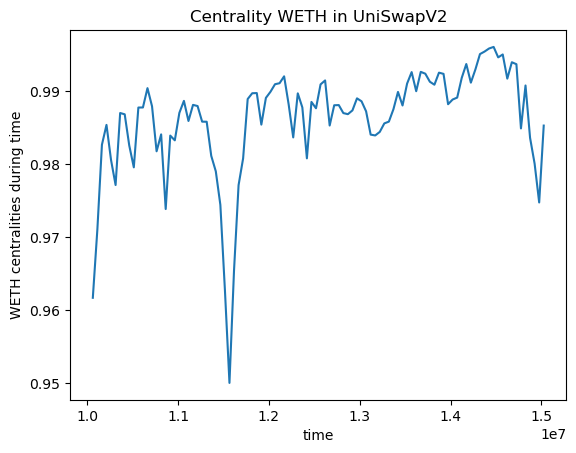

In [15]:
uni_multi_graph.draw_centralities("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

1 0.019596545041740514
2 0.019596545041740514
3 0.019596545041740514
4 0.019596545041740514
5 0.019596545041740514
6 0.019596545041740514
7 0.019596545041740514
8 0.019596545041740514
9 0.019596545041740514
10 0.019596545041740514
11 0.019596545041740514
12 0.019596545041740514
13 0.019596545041740514
14 0.019596545041740514
15 2.526816211037255e-06
16 0.16876525234460626
17 0.202660246976966
18 0.19898346094808542
19 0.18376485570263776
20 0.13526761225978914
21 0.20845964024864883
22 0.22953646648941448
23 0.2017800650611185
24 0.15473497477590048
25 0.16270049640348716
26 0.2852280608432404
27 0.19086726363636783
28 0.21996135627580124
29 0.291546599916239
30 0.23866838900759882
31 0.0801848856000742
32 0.24641723599413656
33 0.28465091117664815
34 0.2707596520391442
35 0.22970830954578114
36 0.2614285034881874
37 0.2457544112845018
38 0.34122602289193493
39 0.3072984016010065
40 0.32177963385134645
41 0.32183458914426966
42 0.341765872089842
43 0.29095969327882654
44 0.315393867417

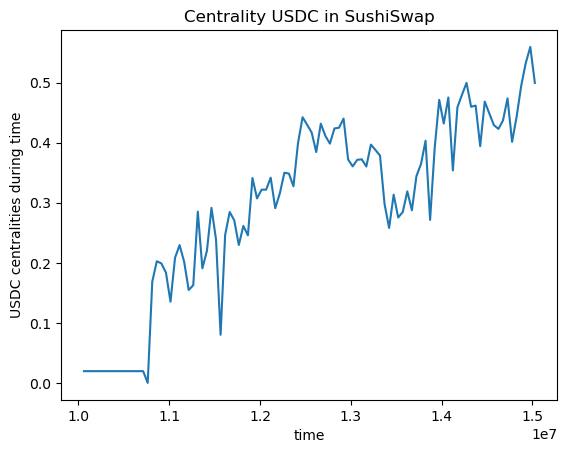

In [9]:
sushi_multi_graph.draw_centralities("0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48")

1 0.11630860302646083
2 0.09342529808570652
3 0.06942719512461801
4 0.05621802953144725
5 0.09726327147429518
6 0.09588827420789649
7 0.07946578972575254
8 0.07227119777912214
9 0.08263589558099671
10 0.07840821536111336
11 0.06471754359675214
12 0.06153146225228904
13 0.058609925239961995
14 0.05111633408513659
15 0.062188626477970514
16 0.08176870267226403
17 0.08151884712396494
18 0.06930345297546602
19 0.10073451474883621
20 0.07998661549428593
21 0.07973301807815848
22 0.10102307336581413
23 0.08487530900556568
24 0.08519936475337218
25 0.09438107231821488
26 0.09683838331540663
27 0.08951738491765926
28 0.0904512683693095
29 0.14527024904416216
30 0.18730755885006795
31 0.15181010728514288
32 0.1591458982858694
33 0.13729027918415126
34 0.1308619393493844
35 0.09202222321799663
36 0.09034837217306828
37 0.08441941260937595
38 0.10976718626161362
39 0.09247372769824788
40 0.07912728970201996
41 0.07654288559494488
42 0.08095224554896178
43 0.06975000220591544
44 0.1066486280469369

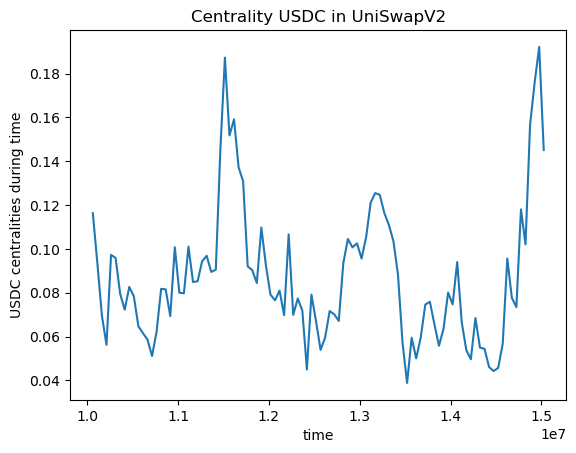

In [13]:
uni_multi_graph.draw_centralities("0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48")

1 0.019596545041740514
2 0.019596545041740514
3 0.019596545041740514
4 0.019596545041740514
5 0.019596545041740514
6 0.019596545041740514
7 0.019596545041740514
8 0.019596545041740514
9 0.019596545041740514
10 0.019596545041740514
11 0.019596545041740514
12 0.019596545041740514
13 0.019596545041740514
14 0.019596545041740514
15 2.526816211037255e-06
16 0.7397670471324119
17 0.6753388183450925
18 0.6774602641857247
19 0.7312997630665621
20 0.7267171035973414
21 0.68172809176259
22 0.7282679224596335
23 0.6808959987767313
24 0.7311485242220367
25 0.7331023091320075
26 0.6797406103932978
27 0.7344031549306058
28 0.7336733860416049
29 0.6801138012460379
30 0.6790979133167675
31 0.40337656382533893
32 0.6014181627813476
33 0.7220350803316308
34 0.7165544181707373
35 0.7212124656730731
36 0.6818735553797897
37 0.7233974558932134
38 0.7257163683842406
39 0.6835895525990657
40 0.6842001212776083
41 0.6854548776515861
42 0.681526895291904
43 0.7224521750112428
44 0.686470916420576
45 0.72493132

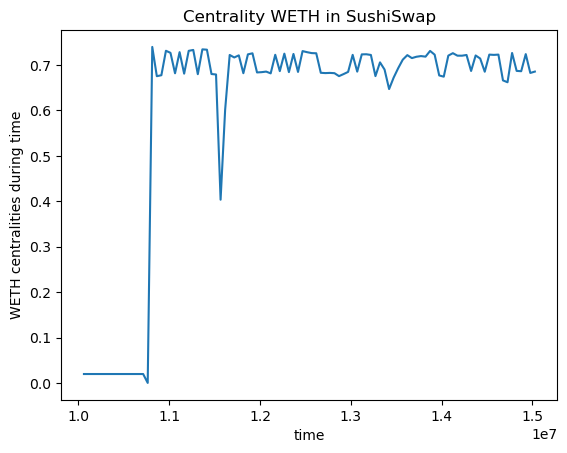

In [20]:
sushi_multi_graph.draw_centralities("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

1 0.018450356834171257
2 0.012964802632345587
3 0.012374628497253844
4 0.006017551859200235
5 0.006386388980881501
6 0.009394230782047703
7 0.0042900730241646895
8 0.0033357773560010982
9 0.003000356972754859
10 0.0045563245558563675
11 0.003066789822864882
12 0.0019083169207863534
13 0.0031807315288902727
14 0.0022679316530897203
15 0.002301638403812408
16 0.005065622179076985
17 0.014215701471571
18 0.011216257643601448
19 0.008423427454352029
20 0.008459894373881758
21 0.014437145778231937
22 0.014417968302361459
23 0.014485843551152571
24 0.014476919012641426
25 0.019340484838685754
26 0.013660552175153946
27 0.02150965078207574
28 0.014053289802516387
29 0.014519301370764574
30 0.01699128392696454
31 0.01949233060323312
32 0.021428102050198183
33 0.017888216347955725
34 0.04435453967801756
35 0.028405673188654477
36 0.028539381869271307
37 0.02368595805079534
38 0.025368892511626537
39 0.021149834593240352
40 0.011595697025385036
41 0.008680960551485555
42 0.01103615033580699
43 0

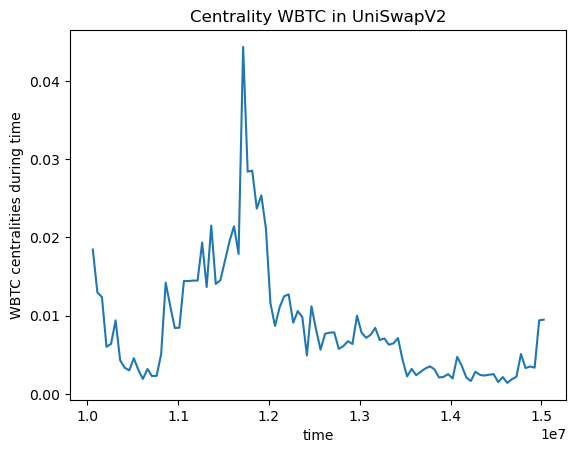

In [22]:
uni_multi_graph.draw_centralities("0x2260fac5e5542a773aa44fbcfedf7c193bc2c599")

1 0.019596545041740514
2 0.019596545041740514
3 0.019596545041740514
4 0.019596545041740514
5 0.019596545041740514
6 0.019596545041740514
7 0.019596545041740514
8 0.019596545041740514
9 0.019596545041740514
10 0.019596545041740514
11 0.019596545041740514
12 0.019596545041740514
13 0.019596545041740514
14 0.019596545041740514
15 2.526816211037255e-06
16 7.522554983947962e-05
17 0.0
18 0.0013520871899083244
19 0.02147893180377462
20 0.012318776867120835
21 0.00234405795981992
22 0.0028806289537118093
23 0.017449944233971885
24 0.019982674328856385
25 0.08470896329488314
26 0.1139562669470122
27 0.08181761067641453
28 0.08824238823418641
29 0.14112378573735257
30 0.1331754984691642
31 0.05209337235469693
32 0.12898792989857688
33 0.15503167112519212
34 0.24709563256088826
35 0.18299409468416486
36 0.24268755237999062
37 0.15316563178427076
38 0.13247020344216745
39 0.14136447880786795
40 0.12494357431838385
41 0.11465118006813534
42 0.12453721614044767
43 0.127049476909008
44 0.1327182483

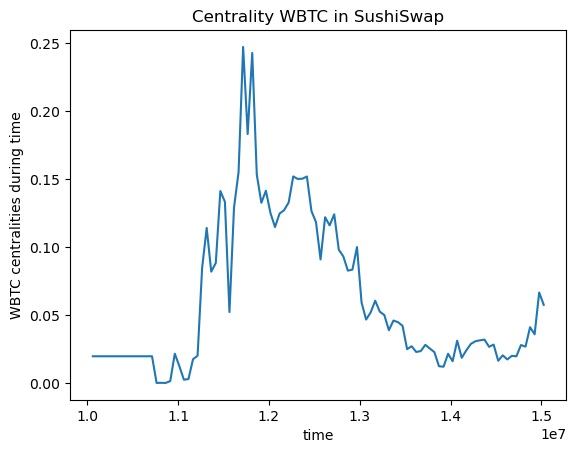

In [24]:
sushi_multi_graph.draw_centralities("0x2260fac5e5542a773aa44fbcfedf7c193bc2c599")

1 3.397855770565608e-05
2 1.1927141336104495e-05
3 7.787683132318342e-06
4 5.4212178911713815e-06
5 4.341528878913324e-06
6 2.6015593414698708e-06
7 2.185467663863826e-06
8 1.989133784138997e-06
9 1.5959345599759886e-06
10 1.1331321949406535e-06
11 9.515326785184249e-07
12 6.271169637812534e-07
13 5.906650935729383e-07
14 5.579167658277295e-07
15 3.8938223715317355e-07
16 4.843314063559599e-07
17 4.091202541678706e-07
18 3.9863018955828425e-07
19 3.8342334445591637e-07
20 4.1676409546685837e-07
21 4.626548879420582e-07
22 4.5678520790652153e-07
23 4.5027644621406127e-07
24 5.215404212350102e-07
25 4.936945715044228e-07
26 5.047872357975738e-07
27 2.6948309635858e-05
28 0.0019902730088369232
29 0.00024536347759222647
30 0.0001247572101054897
31 0.001007093630357015
32 0.009570911547291411
33 0.007870466624824839
34 0.01719821055656339
35 0.025505616375413237
36 0.009766485642506775
37 0.00659217951347343
38 0.004510360476268644
39 0.00536649287136192
40 0.002240581341990645
41 0.0015959

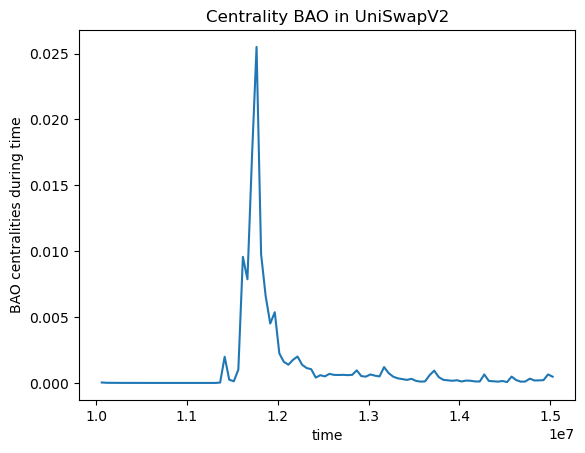

In [25]:
uni_multi_graph.draw_centralities("0x374cb8c27130e2c9e04f44303f3c8351b9de61c1")

1 0.019596545041740514
2 0.019596545041740514
3 0.019596545041740514
4 0.019596545041740514
5 0.019596545041740514
6 0.019596545041740514
7 0.019596545041740514
8 0.019596545041740514
9 0.019596545041740514
10 0.019596545041740514
11 0.019596545041740514
12 0.019596545041740514
13 0.019596545041740514
14 0.019596545041740514
15 2.526816211037255e-06
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 6.106948915944979e-125
32 0.0
33 0.0012294772069669912
34 0.025303182320487526
35 0.12416509927157196
36 0.06819914004862265
37 0.053569863898510726
38 0.03016392416961534
39 0.060032338653992656
40 0.03215960374270627
41 0.02540809594769483
42 0.024168724390480685
43 0.03439820096170745
44 0.03766414104802849
45 0.026543767777934598
46 0.02217264696331244
47 0.017571042473262966
48 0.010223067623233077
49 0.009228184480754334
50 0.0102828515342462
51 0.014147987161116003
52 0.01040971516363784
53 0.010654987918979642
54 0.01235459444

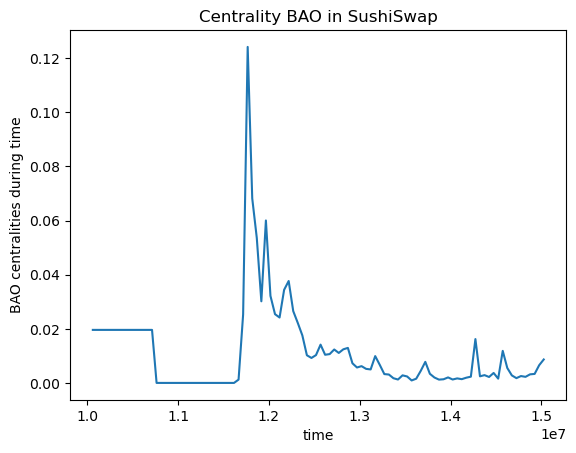

In [26]:
sushi_multi_graph.draw_centralities("0x374cb8c27130e2c9e04f44303f3c8351b9de61c1")

<h2><span style="color:orange">Wiered Graphs</span></h2>

In [29]:
sushi_wierd_graph = sushi_multi_graph.graphs[34]
eigen_vec = sushi_wierd_graph.get_eigen_centrality()
eigen_vec = sushi_wierd_graph.get_reversed_sorted_ranks(eigen_vec)
eigen_vec = sushi_wierd_graph.change_ranks_with_symbol(eigen_vec)
sushi_wierd_graph.get_top_ranks(eigen_vec, 50)

[('WETH', 0.7212124656730731),
 ('SUSHI', 0.4040476800095694),
 ('USDC', 0.22970830954578114),
 ('USDT', 0.22443554256656228),
 ('WBTC', 0.18299409468416486),
 ('DAI', 0.15369118960213238),
 ('ALPHA', 0.1396967917927249),
 ('BAO', 0.12416509927157196),
 ('RUNE', 0.12066783299499602),
 ('CREAM', 0.11051677160033935),
 ('YFI', 0.1093050976402485),
 ('AAVE', 0.09830931113406063),
 ('COMP', 0.09335340193368763),
 ('CRV', 0.09261779134569577),
 ('SNX', 0.08936289327669746),
 ('UMA', 0.08830442920938679),
 ('LINK', 0.0804943658270396),
 ('UNI', 0.0775777070040807),
 ('CRD', 0.049779715453653714),
 ('REN', 0.04967461468144693),
 ('OPIUM', 0.04583520551279368),
 ('BAND', 0.045572238183403),
 ('KP3R', 0.042148218383005386),
 ('RGT', 0.04204847596956804),
 ('FTM', 0.041601431509603895),
 ('ARMOR', 0.03457342638765358),
 ('HEGIC', 0.03424507286430474),
 ('LON', 0.0335287572813776),
 ('COVER', 0.028847516034156435),
 ('sUSD', 0.026418551687660684),
 ('BADGER', 0.024780156970772925),
 ('NFTX', 0.02

In [33]:
print(get_block_range(34))

[11766203.64, 11816361.1]


In [158]:
degree_list = dict(sushi_wierd_graph.crypto_graph.degree(weight = 'weight'))
degree_list = sushi_wierd_graph.get_reversed_sorted_ranks(degree_list)
degree_list = sushi_wierd_graph.change_ranks_with_symbol(degree_list)
sushi_wierd_graph.get_top_ranks(degree_list, 20)

[('WETH', 184464),
 ('USDT', 27651),
 ('COVER', 21576),
 ('USDC', 21042),
 ('SUSHI', 18035),
 ('DAI', 15740),
 ('YFI', 10720),
 ('SNX', 9986),
 ('WBTC', 9702),
 ('LINK', 8340),
 ('DSD', 4028),
 ('KP3R', 3524),
 ('UNI', 3199),
 ('UMA', 2968),
 ('AAVE', 2610),
 ('CRV', 2500),
 ('COMP', 2324),
 ('REN', 2268),
 ('sUSD', 1858)]

In [23]:
uni_wierd_graph = uni_multi_graph.graphs[33]
eigen_vec = uni_wierd_graph.get_eigen_centrality()
eigen_vec = uni_wierd_graph.get_reversed_sorted_ranks(eigen_vec)
print(list(eigen_vec)[0:20])
eigen_vec = uni_wierd_graph.change_ranks_with_symbol(eigen_vec)
uni_wierd_graph.get_top_ranks(eigen_vec, 50)

['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', '0xdac17f958d2ee523a2206206994597c13d831ec7', '0x6b175474e89094c44da98b954eedeac495271d0f', '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599', '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', '0x374cb8c27130e2c9e04f44303f3c8351b9de61c1', '0x1337def16f9b486faed0293eb623dc8395dfe46a', '0x8c8687fc965593dfb2f0b4eaefd55e9d8df348df', '0x3c03b4ec9477809072ff9cc9292c9b25d4a8e6c6', '0x3472a5a71965499acd81997a54bba8d852c6e53d', '0x220b71671b649c03714da9c621285943f3cbcdc6', '0x514910771af9ca656af840dff83e8264ecf986ca', '0x00a8b738e453ffd858a7edf03bccfe20412f0eb0', '0x0d6ae2a429df13e44a07cd2969e085e4833f64a0', '0xa4eed63db85311e22df4473f87ccfc3dadcfa3e3', '0x798d1be841a82a273720ce31c822c61a67a601c3', '0x73968b9a57c6e53d41345fd57a6e6ae27d6cdb2f', '0x0b38210ea11411557c13457d4da7dc6ea731b88a', '0x83e6f1e41cdd28eaceb20cb649155049fac3d5aa']


[('WETH', 0.9807606133641068),
 ('USDC', 0.1308619393493844),
 ('USDT', 0.0946575713729435),
 ('DAI', 0.07609546250717358),
 ('WBTC', 0.04435453967801756),
 ('UNI', 0.021295767511299885),
 ('BAO', 0.01719821055656339),
 ('ARMOR', 0.014018549347886714),
 ('PAID', 0.012945309883228142),
 ('CVR', 0.0122921823619498),
 ('BADGER', 0.010837911134690549),
 ('DIS', 0.010706992529079033),
 ('LINK', 0.010688429443208745),
 ('ALBT', 0.010140818410035207),
 ('PBR', 0.0095023459565492),
 ('RBC', 0.008968412986648508),
 ('DIGG', 0.008832609358439549),
 ('SDT', 0.008717322825139854),
 ('API3', 0.008669449603684898),
 ('POLS', 0.0083431300941756),
 ('ALPHA', 0.00800215551687397),
 ('ROOK', 0.00778428350902794),
 ('DSD', 0.007667042966689271),
 ('BBP', 0.007647502876299492),
 ('MIR', 0.007546871410792134),
 ('UST', 0.007189287756659192),
 ('RAMP', 0.006871761287825292),
 ('AAVE', 0.006653889279979266),
 ('MPH', 0.006546418782835483),
 ('ARTH', 0.006415500177223968),
 ('DAIQ', 0.006327569770469966),
 ('

<h2><span style="color:orange">Degree Weight Distribution</span></h2>

In [12]:
degree_list = dict(uni_graph.crypto_graph.degree(weight = 'weight'))
degree_list = uni_graph.get_reversed_sorted_ranks(degree_list)
degree_list = uni_graph.change_ranks_with_symbol(degree_list)
degree_list = [x[1] for x in degree_list]
count_degree = uni_graph.get_count_deg(degree_list)
print(count_degree)

NameError: name 'uni_graph' is not defined

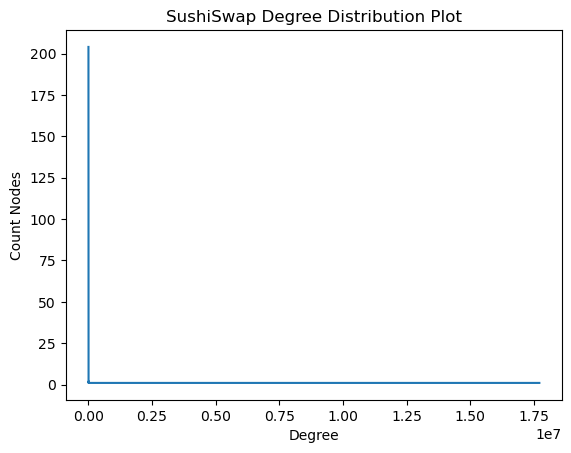

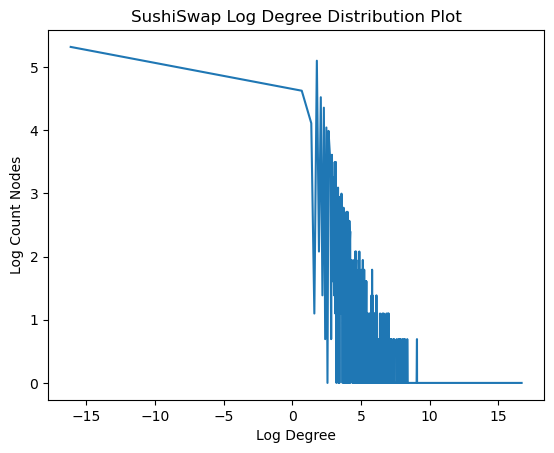

In [47]:
degree_list = dict(sushi_graph.crypto_graph.degree(weight = 'weight'))
degree_list = sushi_graph.get_reversed_sorted_ranks(degree_list)
degree_list = sushi_graph.change_ranks_with_symbol(degree_list)
degree_list = [x[1] for x in degree_list]
count_degree = sushi_graph.get_count_deg(degree_list)
# count_degree = [(x[1], x[0]) for x in count_degree]
sushi_graph.plot_degree(count_degree)
sushi_graph.plot_log_degree(count_degree)